# Castañas

En este documento se va a crear un modelo para las castañas para su posterior análisis con XAI

## Carga de datos ya aumentados

In [1]:
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import numpy as np

2025-05-23 15:31:45.004135: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
dataset_dir = 'castanas_aug_ds'

train, val = keras.utils.image_dataset_from_directory (
    directory=dataset_dir,
    batch_size=32,
    shuffle=True,
    labels="inferred" ,
    class_names= ["no_comible", "comible"],
    label_mode='binary',
    color_mode='rgb',
    image_size=(256,256),
    validation_split=0.2,
    subset='both',
    seed=69,
    )


Found 2186 files belonging to 2 classes.
Using 1749 files for training.
Using 437 files for validation.


In [49]:
def ver_imgs(dataset: tf.data.Dataset):
    clases = ['no comible', 'comible']
    plt.figure(figsize=(5,5))
    # plt.subplots_adjust(hspace=10)

    imgs, labels = next(iter(dataset.take(1)))

    for i in range(3):
        img, label = imgs[i], labels[i]
        ax = plt.subplot(1,3,i+1)
        ax.set_axis_off()
        plt.imshow( img.numpy().astype('uint8') )
        plt.title ( clases[int(label.numpy())])


    plt.tight_layout()
    plt.show()
        

/tmp/ipykernel_40031/346393394.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title ( clases[int(label.numpy())])


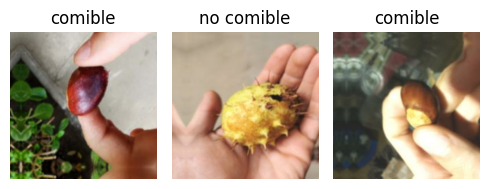

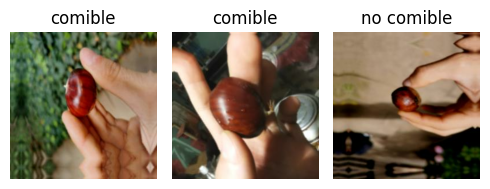

In [50]:
ver_imgs(train)
ver_imgs(val)

## Modelo CNN

In [ ]:
model = keras.Sequential([
    keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    keras.layers.Conv2D( filters=32, kernel_size=(4,4), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2) ,
    keras.layers.Conv2D( filters=64, kernel_size=(4,4), activation='relu' ),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2) ,
    keras.layers.Conv2D( filters=64, kernel_size=(4,4), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2) ,
    keras.layers.Conv2D( filters=64, kernel_size=(4,4), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2) ,
    keras.layers.Conv2D( filters=64, kernel_size=(4,4), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2) ,
    
    keras.layers.Flatten(),
    keras.layers.Dense(units= 128, activation='relu'),
    keras.layers.Dropout(0.2) ,
    keras.layers.Dense(units= 64, activation='relu'),
    keras.layers.Dropout(0.2) ,
    keras.layers.Dense(units= 32, activation='relu'),
    keras.layers.Dropout(0.2) ,
    keras.layers.Dense(units= 1, activation='sigmoid'),

],
trainable=True,
)

model.summary()

/mnt/c/Users/Aaron/Pictures/castanas-xai/pyenv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 253, 253, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 123, 123, 64)   │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 58, 58, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 26, 26, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 10, 10, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,060,897 (4.05 MB)

 Trainable params: 1,060,897 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.compile(
    optimizer='adam',
    loss=keras.losses.binary_crossentropy,
    metrics=['accuracy']
    )

In [51]:
history = model.fit(
    train,
    epochs=10, 
    validation_data=val
)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 249s 4s/step - accuracy: 0.6595 - loss: 0.6423 - val_accuracy: 0.7208 - val_loss: 0.5073
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 243s 4s/step - accuracy: 0.6633 - loss: 0.5094 - val_accuracy: 0.7757 - val_loss: 0.4256
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - accuracy: 0.7472 - loss: 0.4352 - val_accuracy: 0.7757 - val_loss: 0.3890
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 243s 4s/step - accuracy: 0.7884 - loss: 0.3995 - val_accuracy: 0.7735 - val_loss: 0.3874
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.8163 - loss: 0.3666 - val_accuracy: 0.7506 - val_loss: 0.4641
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.8260 - loss: 0.3532 - val_accuracy: 0.8146 - val_loss: 0.3550
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.8405 - loss: 0.3031 - val_accuracy: 0.8169 - val_loss: 0.4050
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 250s 5s/step - accuracy: 0.8780 - loss: 0.2624 - val_accuracy: 0.8169 - v

In [54]:
model.save("modelos/Castanas_Model_1.keras")

In [56]:
print(history.history.keys() )

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


14/14 - 15s - 1s/step - accuracy: 0.7689 - loss: 0.5462
val accuaricy: 0.768878698348999 val loss: 0.5461703538894653


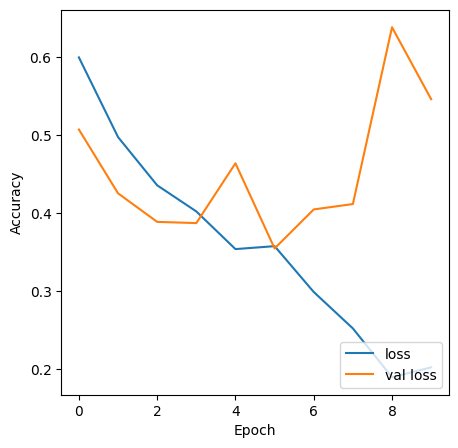

In [58]:
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

val_loss, val_acc = model.evaluate(val, verbose=2)
print(f'val accuaricy: {val_acc} val loss: {val_loss}')